<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Дополнение" data-toc-modified-id="Дополнение-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Дополнение</a></span></li></ul></div>

# Проект: "Поиск токсичных комментариев"

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [3]:
# проверка наличия библиотек
try:
    import lightgbm as lgbm
    print('LightGBM ver.:', lgbm.__version__)
except:
    !pip install lightgbm

try:
    import optuna
    print('Optuna ver.:', optuna.__version__)
except:
    !pip install optuna

LightGBM ver.: 3.3.5
Optuna ver.: 3.1.0


In [4]:
# загрузка библиотек
import pandas as pd
import numpy as np
import re

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import f1_score

from lightgbm import LGBMClassifier

from optuna.integration import OptunaSearchCV
from optuna.distributions import CategoricalDistribution, FloatDistribution, IntDistribution

from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.naive_bayes import ComplementNB
from sklearn.dummy import DummyClassifier

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.probability import FreqDist
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [5]:
try:
    import pandarallel
    print('pandarallel installed')
except:
    !pip install pandarallel

# параллелизация
from tqdm.notebook import tqdm
tqdm.pandas()
from pandarallel import pandarallel   
tqdm.pandas(desc="progress")
pandarallel.initialize(progress_bar = True)

pandarallel installed
INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [11]:
# словари для обучения
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('punkt')
stopwords_en = stopwords.words('english')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\LSH\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\LSH\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\LSH\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LSH\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\LSH\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
# чтение файла данных из папки по умолчанию и из рабочей директории с парсингом дат
try:
    data = pd.read_csv('/datasets/toxic_comments.csv')
except:
    data = pd.read_csv('toxic_comments.csv')

# пример данных
data.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [6]:
# примеры токсичных комментариев
data[data['toxic']==1]

,Unnamed: 0,text,toxic
6,6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
12,12,Hey... what is it..\n@ | talk .\nWhat is it......,1
16,16,"Bye! \n\nDon't look, come or think of comming ...",1
42,42,You are gay or antisemmitian? \n\nArchangel WH...,1
43,43,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1
...,...,...,...
159215,159374,"""\n\n our previous conversation \n\nyou fuckin...",1
159235,159394,YOU ARE A MISCHIEVIOUS PUBIC HAIR,1
159262,159421,Your absurd edits \n\nYour absurd edits on gre...,1
159267,159426,"""\n\nHey listen don't you ever!!!! Delete my e...",1


In [7]:
print(f'Общее число комментариев: {len(data) :.0f}')
print(f'Доля токсичных комментариев: {data["toxic"].mean() :.1%}')

Общее число комментариев: 159292
Доля токсичных комментариев: 10.2%


In [8]:
print(f'Число пропусков: {data["toxic"].isna().sum() :.0f}')
print(f'Количество дубликатов: {data.duplicated().sum() :.0f}')

# удаление старого индекса
try:
    data.drop('Unnamed: 0', axis=1, inplace=True)
except:
    pass

Число пропусков: 0
Количество дубликатов: 0


Кажется, что часть комментариев из корпуса была удалена. Об этом говорит несовпадение сгенерированного и сходного индексов.  
Классы в целевом признаке сильно несбалансированны - это потребует введения определенных мер на этапе подготовки классификаторов.
Первичный обзор данных позволяет предположить, что все тексты англоязычные, а для успешной их обработки стоит провести некоторую чистку и привести их все к нижнему регистру.

## Обучение

Для успешного построения модели классификатора корпуса имеющихся текстов следует прежде значительно расширить признаковое пространство. Превратим тексты комментариев в вектора. Используем для этого подходы _Bag-of-Words_ и _TF-IDF_. Для реализации используем средства библиотек _NLTK_ и _SciKit-Learn_.

Шаги реализации:  
1. С помощью регулярных выражений очищаем комментарии от цифр, знаков препинания, служебных слов.
2. Делаем токенизацию.
3. Делаем лемматизацию с использованием функции `pos_tag` из библиотеки  _NLTK_.
4. Делаем векторизацию средствами _SciKit-Learn_ c очисткой от стоп-слов.
5. Обучаем классификатор на полученных векторах комментариев.

In [9]:
# функция лемматизации и токенизации
def get_lemma(text):
    # импорты для pandarallel
    import nltk
    from nltk.corpus import wordnet
    
    # оставляем только латинские символы и апостроф, использующийся в английских словах
    ret = nltk.tokenize.RegexpTokenizer(r'[a-zA-Z\']+')
    tokens = ret.tokenize(text)
    lemma = []    
    wnl = nltk.stem.WordNetLemmatizer()
    # лемматизация с использованим частей речи
    for token in tokens:
         # раскрытие списка результатов после POS-теггинга, взятие POS, взятие начальной буквы из POS
        tag = nltk.pos_tag([token])[0][1][0].upper()
        # пользовательский словарь тегов POS
        tag_dict = {"J": wordnet.ADJ,
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV}
        # получение нужного POS-тега или тега сущиствительного по умолчанию
        wordnet_pos = tag_dict.get(tag, wordnet.NOUN)
        lemma.append(wnl.lemmatize(token, wordnet_pos))
    # воссоздание текста из списка лемм
    return str.lower(' '.join(map(str, lemma)))

In [10]:
# проверка функции лемматизации
sentence1 = "The striped bats are hanging on their feet for best"
sentence2 = "you should be ashamed of yourself went worked"
test_df = pd.DataFrame([sentence1, sentence2], columns=['text'])

test_df['text'].apply(get_lemma)

0    the strip bat be hang on their foot for best
1       you should be ashamed of yourself go work
Name: text, dtype: object

In [13]:
sentence1 = 'if you read carefully my comment was overall'
sentence2 = "did you make it at wp ae ofshalott"
test_df = pd.DataFrame([sentence1, sentence2], columns=['text'])
test_df['text'].apply(get_lemma)

0    if you read carefully my comment be overall
1              do you make it at wp ae ofshalott
Name: text, dtype: object

In [12]:
df = data.copy()
# лемматизация текстов в корпусе
# df['lemmatized_text'] = df['text'].apply(get_lemma)
df['lemmatized_text'] = df['text'].parallel_apply(get_lemma)
df

,text,toxic,lemmatized_text
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits make under my userna...
1,D'aww! He matches this background colour I'm s...,0,d'aww he match this background colour i'm seem...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i'm really not try to edit war it's ju...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i can't make any real suggestion on impro...
4,"You, sir, are my hero. Any chance you remember...",0,you sir be my hero any chance you remember wha...
...,...,...,...
159287,""":::::And for the second time of asking, when ...",0,and for the second time of ask when your view ...
159288,You should be ashamed of yourself \n\nThat is ...,0,you should be ashamed of yourself that be a ho...
159289,"Spitzer \n\nUmm, theres no actual article for ...",0,spitzer umm there no actual article for prosti...
159290,And it looks like it was actually you who put ...,0,and it look like it be actually you who put on...


In [15]:
# полный список слов корпуса комментариев
comments_corpus = map(word_tokenize, df.loc[:, 'lemmatized_text'])
comments_tokens = list(comments_corpus)[0]
text_object = nltk.Text(comments_tokens)

# построение словаря частотных слов для корпуса комментариев
fdist = FreqDist(text_object)
fdist.most_common(10)

[('the', 3),
 ("n't", 2),
 ('i', 2),
 ('explanation', 1),
 ('why', 1),
 ('edits', 1),
 ('make', 1),
 ('under', 1),
 ('my', 1),
 ('username', 1)]

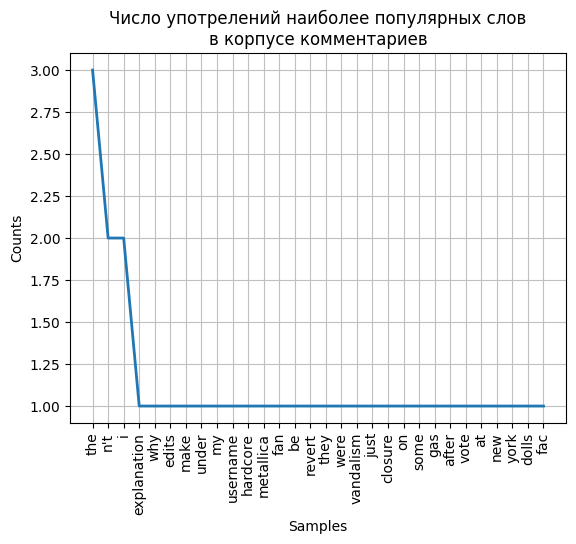

In [16]:
# график самых популярых слов
fdist.plot(30, cumulative=False, title='Число употрелений наиболее популярных слов\nв корпусе комментариев');

Для векторизации мы спользуем функции `CountVectorizer`, `TfidfVectorizer` из _SciKit-Learn_. В качестве признаков будут выступать выделенные _уни-_ и _биграммы_. Признаковое пространство хорошо бы дополнили _n-граммы_, составленные из букв в пределах слов - это позволило бы учесть разночтение в написании слов, но сильно раздуло бы число признаков. Так как оно и без того составляет _>1e-6_ средствами _Scikit-Learn_ отберем наиболее значимые, в размере сопоставимом с объемом корпуса текстов датасета.

Из-за большого числа признаков и размера самого датасета целесообразно для подбора моделей и гиперпараметров ограничить и то и другое.

In [17]:
# создание стратифицированных выборок 
features_train, features_test, target_train, target_test = train_test_split(
    df['lemmatized_text'], df['toxic'], test_size=0.2, stratify=df['toxic'], random_state=42
)

# усеченный обучающий датасет
features_cutted = features_train.sample(frac=.1, random_state=42).copy()
target_cutted = target_train[features_cutted.index]

In [18]:
# усеченный векторизатор
vectorizer_cutted = Pipeline([
    ('vec', FeatureUnion([
        ('bow_words', CountVectorizer(ngram_range=(1,2), stop_words=stopwords_en)),
        ('tfidf', TfidfVectorizer(ngram_range=(2,2), stop_words=stopwords_en))
    ])),
    # ограничение числа признаков
    ('chi2', SelectKBest(chi2, k=1000))
])

# список моделей с параметрами для optuna
models = [
    ('LGBMClassifier', LGBMClassifier(class_weight='balanced', random_state=42), {
        'clf__learning_rate': FloatDistribution(0.1, 0.4, 0.1),
        'clf__n_estimators': IntDistribution(100, 300, 50),
        'clf__max_depth': IntDistribution(6, 20, 2)
    }),   
    ('LogisticRegression', LogisticRegression(class_weight='balanced', max_iter=500, random_state=42), {
        'clf__C': FloatDistribution(0.1, 1.0, 0.1)
    }),
    ('RidgeClassifier', RidgeClassifier(class_weight='balanced', random_state=42), {
        'clf__alpha': FloatDistribution(0.1, 1.0, 0.1)
    }),
    ('NearestCentroid', NearestCentroid(), {
        'clf__metric': CategoricalDistribution(['euclidean', 'manhattan'])
    }),
    ('ComplementNB', ComplementNB(), {
        'clf__alpha': FloatDistribution(0.1, 1.0, 0.1)
    }),
    ('DummyClassifier', DummyClassifier(), {
        'clf__strategy': CategoricalDistribution(['most_frequent', 'prior', 'stratified', 'uniform'])
    })
]

In [19]:
# список результатов и обученных моделей
results = []
# проход по списку моделей
for name, model, param in models:
    search_cv = OptunaSearchCV(estimator=Pipeline(steps=[('vec', vectorizer_cutted), ('clf', model)]),
                               param_distributions=param,
                               scoring='f1',
                               verbose=0,
                               n_jobs=-1,
                               n_trials=10,
                               cv=3,
                               random_state=42
                              ).fit(X=features_cutted, y=target_cutted)
    # запись имени модели, точности и гиперпараметров
    results.append((name, search_cv.best_score_, search_cv.best_estimator_))
    print('Точность модели %s по F1-мере: %f' % (name, search_cv.best_score_))

C:\Users\LSH\AppData\Local\Temp\ipykernel_1036\1823985768.py:5: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  search_cv = OptunaSearchCV(estimator=Pipeline(steps=[('vec', vectorizer_cutted), ('clf', model)]),
[I 2023-04-01 20:35:21,402] A new study created in memory with name: no-name-5d488d89-41c9-45c0-875e-375065286a9d
[I 2023-04-01 20:36:09,341] Trial 0 finished with value: 0.6001323743436277 and parameters: {'clf__learning_rate': 0.20264199919794346, 'clf__n_estimators': 123, 'clf__max_depth': 8}. Best is trial 0 with value: 0.6001323743436277.
[I 2023-04-01 20:36:13,739] Trial 1 finished with value: 0.5698304491336871 and parameters: {'clf__learning_rate': 0.155227557719179, 'clf__n_estimators': 146, 'clf__max_depth': 15}. Best is trial 0 with value: 0.6001323743436277.
[I 2023-04-01 20:36:18,946] Trial 2 finished with value: 0.5229410551377441 and parameters: {'clf__learning_rate': 0.25522361040174507, 'clf

Точность модели LGBMClassifier по F1-мере: 0.608005


[I 2023-04-01 20:38:27,400] Trial 3 finished with value: 0.6973845009964315 and parameters: {'clf__C': 0.36896395905901835}. Best is trial 3 with value: 0.6973845009964315.
[I 2023-04-01 20:38:29,777] Trial 2 finished with value: 0.6973845009964315 and parameters: {'clf__C': 0.3621496721147326}. Best is trial 3 with value: 0.6973845009964315.
[I 2023-04-01 20:38:36,794] Trial 1 finished with value: 0.7003669845457609 and parameters: {'clf__C': 0.585884076604193}. Best is trial 1 with value: 0.7003669845457609.
[I 2023-04-01 20:38:40,507] Trial 0 finished with value: 0.7004502033255533 and parameters: {'clf__C': 0.8297949256789753}. Best is trial 0 with value: 0.7004502033255533.
[I 2023-04-01 20:39:15,352] Trial 4 finished with value: 0.6879759115988984 and parameters: {'clf__C': 0.18932441482751536}. Best is trial 0 with value: 0.7004502033255533.
[I 2023-04-01 20:39:22,548] Trial 6 finished with value: 0.6800347662774276 and parameters: {'clf__C': 0.11725945574437437}. Best is trial 

Точность модели LogisticRegression по F1-мере: 0.702242


[I 2023-04-01 20:40:46,350] Trial 0 finished with value: 0.6506998332049855 and parameters: {'clf__alpha': 0.26031913199132434}. Best is trial 0 with value: 0.6506998332049855.
[I 2023-04-01 20:40:50,885] Trial 1 finished with value: 0.6555156251848774 and parameters: {'clf__alpha': 0.334095983382123}. Best is trial 1 with value: 0.6555156251848774.
[I 2023-04-01 20:40:55,412] Trial 2 finished with value: 0.6570934180527956 and parameters: {'clf__alpha': 0.44766180325036703}. Best is trial 2 with value: 0.6570934180527956.
[I 2023-04-01 20:41:00,195] Trial 3 finished with value: 0.6469594346952837 and parameters: {'clf__alpha': 0.12873334864250918}. Best is trial 2 with value: 0.6570934180527956.
[I 2023-04-01 20:41:42,467] Trial 4 finished with value: 0.6474662913614971 and parameters: {'clf__alpha': 0.11649423847266673}. Best is trial 2 with value: 0.6570934180527956.
[I 2023-04-01 20:41:47,003] Trial 5 finished with value: 0.6564235197283365 and parameters: {'clf__alpha': 0.49398863

Точность модели RidgeClassifier по F1-мере: 0.657093


[I 2023-04-01 20:43:05,496] Trial 1 finished with value: 0.1606373083478609 and parameters: {'clf__metric': 'euclidean'}. Best is trial 1 with value: 0.1606373083478609.
[I 2023-04-01 20:43:06,916] Trial 3 finished with value: 0.1606373083478609 and parameters: {'clf__metric': 'euclidean'}. Best is trial 1 with value: 0.1606373083478609.
[I 2023-04-01 20:43:07,319] Trial 2 finished with value: 0.1606373083478609 and parameters: {'clf__metric': 'euclidean'}. Best is trial 1 with value: 0.1606373083478609.
[I 2023-04-01 20:43:36,603] Trial 0 finished with value: 0.0 and parameters: {'clf__metric': 'manhattan'}. Best is trial 1 with value: 0.1606373083478609.
[I 2023-04-01 20:43:55,842] Trial 5 finished with value: 0.1606373083478609 and parameters: {'clf__metric': 'euclidean'}. Best is trial 1 with value: 0.1606373083478609.
[I 2023-04-01 20:43:56,325] Trial 4 finished with value: 0.0 and parameters: {'clf__metric': 'manhattan'}. Best is trial 1 with value: 0.1606373083478609.
[I 2023-04

Точность модели NearestCentroid по F1-мере: 0.160637


[I 2023-04-01 20:45:24,791] Trial 2 finished with value: 0.666808561592851 and parameters: {'clf__alpha': 0.7824670610262469}. Best is trial 2 with value: 0.666808561592851.
[I 2023-04-01 20:45:26,471] Trial 3 finished with value: 0.6687244644669642 and parameters: {'clf__alpha': 0.3371125247306905}. Best is trial 3 with value: 0.6687244644669642.
[I 2023-04-01 20:45:27,016] Trial 0 finished with value: 0.6694635577093319 and parameters: {'clf__alpha': 0.10403330230744764}. Best is trial 0 with value: 0.6694635577093319.
[I 2023-04-01 20:45:31,682] Trial 1 finished with value: 0.6691890002616647 and parameters: {'clf__alpha': 0.18747967543074068}. Best is trial 0 with value: 0.6694635577093319.
[I 2023-04-01 20:46:14,997] Trial 4 finished with value: 0.6676072294114769 and parameters: {'clf__alpha': 0.48012532637014443}. Best is trial 0 with value: 0.6694635577093319.
[I 2023-04-01 20:46:20,875] Trial 5 finished with value: 0.6679384943851029 and parameters: {'clf__alpha': 0.5201391905

Точность модели ComplementNB по F1-мере: 0.669464


[I 2023-04-01 20:47:42,416] Trial 1 finished with value: 0.17189763768908561 and parameters: {'clf__strategy': 'uniform'}. Best is trial 1 with value: 0.17189763768908561.
[I 2023-04-01 20:47:43,468] Trial 2 finished with value: 0.0 and parameters: {'clf__strategy': 'prior'}. Best is trial 1 with value: 0.17189763768908561.
[I 2023-04-01 20:47:43,468] Trial 0 finished with value: 0.17226709584596808 and parameters: {'clf__strategy': 'uniform'}. Best is trial 0 with value: 0.17226709584596808.
[I 2023-04-01 20:47:43,499] Trial 3 finished with value: 0.0 and parameters: {'clf__strategy': 'most_frequent'}. Best is trial 0 with value: 0.17226709584596808.
[I 2023-04-01 20:48:33,500] Trial 4 finished with value: 0.10933381630674492 and parameters: {'clf__strategy': 'stratified'}. Best is trial 0 with value: 0.17226709584596808.
[I 2023-04-01 20:48:34,886] Trial 5 finished with value: 0.0 and parameters: {'clf__strategy': 'most_frequent'}. Best is trial 0 with value: 0.17226709584596808.
[I 

Точность модели DummyClassifier по F1-мере: 0.172712


In [20]:
# датафрейм результатов и обученных моделей
df_results = pd.DataFrame(results, columns=['model', 'score', 'params'])
df_results.set_index('model', inplace=True)
df_results

,score,params
model,,
LGBMClassifier,0.608005,"((FeatureUnion(transformer_list=[('bow_words',..."
LogisticRegression,0.702242,"((FeatureUnion(transformer_list=[('bow_words',..."
RidgeClassifier,0.657093,"((FeatureUnion(transformer_list=[('bow_words',..."
NearestCentroid,0.160637,"((FeatureUnion(transformer_list=[('bow_words',..."
ComplementNB,0.669464,"((FeatureUnion(transformer_list=[('bow_words',..."
DummyClassifier,0.172712,"((FeatureUnion(transformer_list=[('bow_words',..."


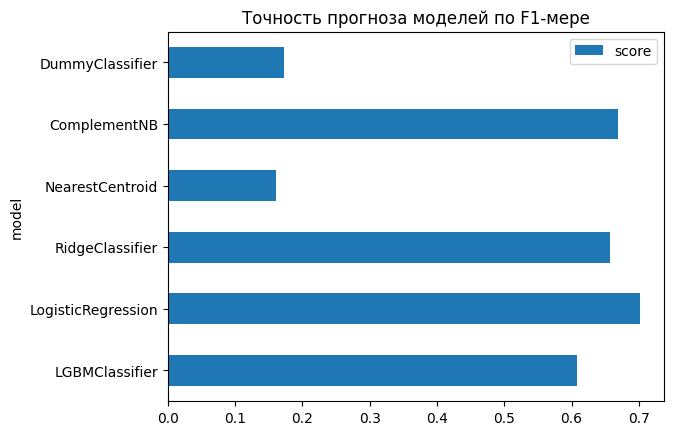

In [21]:
df_results.drop('params', axis=1).plot(kind='barh', title='Точность прогноза моделей по F1-мере');

Лучшие результаты у моделей на сильно усеченных данных пока не достигли необходимого порога точности, но мы вправе ожидать требуемого результата на полном датасете.

In [22]:
# оптимальный векторизатор
vectorizer = Pipeline([
    ('vec', FeatureUnion([
        ('bow_words', CountVectorizer(ngram_range=(1,2), stop_words=stopwords_en)),
        ('tfidf', TfidfVectorizer(ngram_range=(2,2), stop_words=stopwords_en))
    ])),
    ('chi2', SelectKBest(chi2, k=100000))    
])

# данные после векторизации
features_train_transformed = vectorizer.fit_transform(features_train, target_train)
features_test_transformed = vectorizer.transform(features_test)
# выбор лучшей модели
best_name = df_results.query('score == score.max()').index[0]
best_model = df_results.query('score == score.max()').params[0][1]
best_model.fit(features_train_transformed, target_train)
# результаты оценки модели тестовых данных
predictions = best_model.predict(features_test_transformed)                               
score = f1_score(target_test, predictions)
print('Точность прогноза на тестовых данных для %s по F1-мере равна %.3f' %(best_name, score)) 

Точность прогноза на тестовых данных для LogisticRegression по F1-мере равна 0.781


## Выводы

Для решения задачи выявления токсичных комментариев в данном проекте был реализован механизм создания дополнительных предикторов на основе корпуса имеющихся текстов с использованием методов векторизации текстов _Bag-of-Words_ и _TF-IDF_. Перед непосредственно векторизацией тексты были разбиты на токены, из которых были получены леммы. Для данной обработки были использованы инструменты библиотеки _NLTK_. Векторизованы были не только отдельные слова, но и биграммы. Из-за большого числа признаков был проведен отбор наиболее значимых из них. Решено было ограничить их число примерно _2/3_ от размера самого датасета.    
Для осуществления классифицирования над новым пространством признаков было использовано несколько моделей разных типов. Из-за того, что подбор гиперпараметров для них на полном датасете занял бы очень большое время, эта процедура проводилась на малой его части с небольшим количеством признаков. Даже в таких условиях лучшая модель - _LogisticRegression_ - показала неплохое качество прогноза, особенно в сравнении с базовым уровнем _DummyClassifier_. На полном наборе данных выбранная модель предсказуемо преодолела требуемый порог точности _F1-меры_, равный _0.75_.

## Дополнение
__Добавление дополнительных признаков из предобученной модели__

Для увеличения точности прогноза модели решено было добавить дополнительные признаки, полученные из результатов оценки эмоциональной окрашенности текстов с помощью предобученной _VADER (Valence Aware Dictionary for Sentiment Reasoning)_ библиотеки `nltk.sentiment.vader.SentimentIntensityAnalyzer`.  Оценки включат в себе четыре признака `neg`,`neu`,`pos`,`compound`- "негативный", "нейтральный", "позитивный", "совокупно". Для добавления признаков было решено использовать новые классы на основе классов `scikit-learn`. Таким образом все преобразование может быть реализовано в виде одного пайплайна.

In [7]:
class Lemmatizer(BaseEstimator, TransformerMixin):

    def __init__(self):
        self.sentence_column = None
        pass

    def fit(self, X, y=None):
        # проверка типа pd.Series
        assert (type(X) == pd.core.series.Series and X.dtype == 'object'), 'X must be pd.Series and his type must be "object".'
        # проверка наличия названия у серии
        assert (X.name is not None), 'X column is unnamed.'
        self.sentence_column = X.name
        return self

    # функция определения части речи для токена
    def __get_wordnet_pos__(self, word):
        # раскрытие списка результатов после POS-теггинга, взятие POS, взятие начальной буквы из POS
        tag = nltk.pos_tag([word])[0][1][0].upper()
        # пользовательский словарь тегов POS
        tag_dict = {"J": wordnet.ADJ,
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV}
        # получение нужного POS-тега или тега сущиствительного по умолчанию
        return tag_dict.get(tag, wordnet.NOUN)

    # функция лемматизации и токенизации
    def __get_lemma__(self, text):
        # оставляем только латинские символы и апостроф, использующийся в английских словах
        ret = nltk.tokenize.RegexpTokenizer(r'[a-zA-Z\']+')
        tokens = ret.tokenize(text)
        lemma = []
        wnl = nltk.stem.WordNetLemmatizer()
        # лемматизация с использованим частей речи
        for token in tokens:
            lemma.append(wnl.lemmatize(token, self.__get_wordnet_pos__(token)))
        # воссоздание текста из списка лемм
        return str.lower(' '.join(map(str, lemma)))

    def transform(self, X):
        assert (type(X) == pd.core.series.Series and X.dtype == 'object'), 'X must be pd.Series and his type must be "object".'
        column_to_lemmatize = X.copy()
        # проверка совпадения названий серий для трансформации и обучения
        assert (X.name == self.sentence_column), 'X to transform must have same name as X fitted.'
        return column_to_lemmatize.apply(self.__get_lemma__)

In [24]:
# проверка класса Lemmatizer
pipe_lem = Pipeline([('lem', Lemmatizer()),
                     ('bow_words', CountVectorizer(ngram_range=(2,2))),
                     ('clf', LogisticRegression())])
pipe_lem.fit(data.loc[:1000, 'text'], data.loc[:1000, 'toxic'])
pred_lem = pipe_lem.predict(data.loc[1000:1100, 'text'])
f1_score(data.loc[1000:1100, 'toxic'], pred_lem)

0.33333333333333337

In [9]:
class SentimentFearures(BaseEstimator, TransformerMixin):

    def __init__(self):
        self.sentence_column = None
        pass

    def fit(self, X, y=None):
        # проверка типа pd.Series
        assert (type(X) == pd.core.series.Series and X.dtype == 'object'), 'X must be pd.Series and his type must be "object".'
        # проверка наличия названия у серии
        assert (X.name is not None), 'X column is unnamed.'
        self.sentence_column = X.name
        return self

    def __get_sentiment_score__(self, text):
        sia = nltk.sentiment.vader.SentimentIntensityAnalyzer()
        return sia.polarity_scores(text)

    def __get_sentiment_new_cols__(self, text_column):
        score = list(text_column.apply(self.__get_sentiment_score__).values)
        return pd.DataFrame(score, index=text_column.index)

    def transform(self, X):
        assert (type(X) == pd.core.series.Series and X.dtype == 'object'), 'X must be pd.Series and his type must be "object".'
        # проверка совпадения названий серий для трансформации и обучения
        assert (X.name == self.sentence_column), 'X to transform must have same name as X fitted.'
        return self.__get_sentiment_new_cols__(X)

In [26]:
# проверка класса SentimentFearures
tr = SentimentFearures()
tr.fit(data.loc[:10, 'text'])
tr.transform(data.loc[:10, 'text'])

,neg,neu,pos,compound
0,0.000,0.897,0.103,0.5574
1,0.099,0.743,0.158,0.2942
2,0.083,0.849,0.068,-0.1779
3,0.022,0.916,0.062,0.5106
4,0.000,0.663,0.337,0.6808
5,0.000,0.464,0.536,0.7964
6,0.531,0.469,0.000,-0.7783
7,0.129,0.773,0.099,-0.1779
8,0.109,0.891,0.000,-0.8020
9,0.000,1.000,0.000,0.0000


In [12]:
pipe = Pipeline([
    ('lem', Lemmatizer()),
    ('new_feats', FeatureUnion([
        ('sia', SentimentFearures()),
        ('vec_pipe', Pipeline([
            ('vec', FeatureUnion([
                ('bow_words', CountVectorizer(
                    ngram_range=(1, 2), stop_words=stopwords_en)),
                ('tfidf', TfidfVectorizer(ngram_range=(2, 2), stop_words=stopwords_en))
            ])),
            ('chi2', SelectKBest(chi2, k=10000))
        ]))
    ]))
])
#pipe

In [32]:
# проверка работоспособности классов в пайплайне
features_train_transformed_class = pipe.fit_transform(data.loc[:30000, 'text'], data.loc[:30000, 'toxic'])
features_test_transformed_class = pipe.transform(data.loc[30000:40000, 'text'])

model_class = LogisticRegression(class_weight='balanced', max_iter=500, random_state=42)
model_class.fit(features_train_transformed_class, data.loc[:30000, 'toxic'])
predictions_class = model_class.predict(features_test_transformed_class)                               
score_class = f1_score(data.loc[30000:40000, 'toxic'], predictions_class)
print('Точность прогноза по F1-мере при проверке работоспобности на классов в пайплайне: %.3f' %(score_class))

Точность прогноза по F1-мере при проверке работоспобности на классов в пайплайне: 0.752


Пайплайн оказался работоспособен, как и сами классы лемматизации и эмоциональной оценки. К сожалению, введение дополнительных признаков не привело к увеличению качества оценки.